# The SwiGLU activation function

SwiGLU is a Gated Linear Unit (GLU) where the sigmoid gating is replace with the Swish "linear" gating. GLU have been found to mitigate the vanishing gradients problem thanks to the soft gating mechanism

$$\operatorname{GLU}(x) = \operatorname{sigmoid}(W_1x+b_1) \odot (W_2x + b_2)$$

The swish activation $\operatorname{Swish}(x)=x\operatorname{sigmoid}(\beta x)$ is a variant of ReLU that is smooth everywhere and mitigates the dying neurons problem (neurons never being updated because they are always negative). Swish is called SiLU when $\beta=1$, it looks like this:


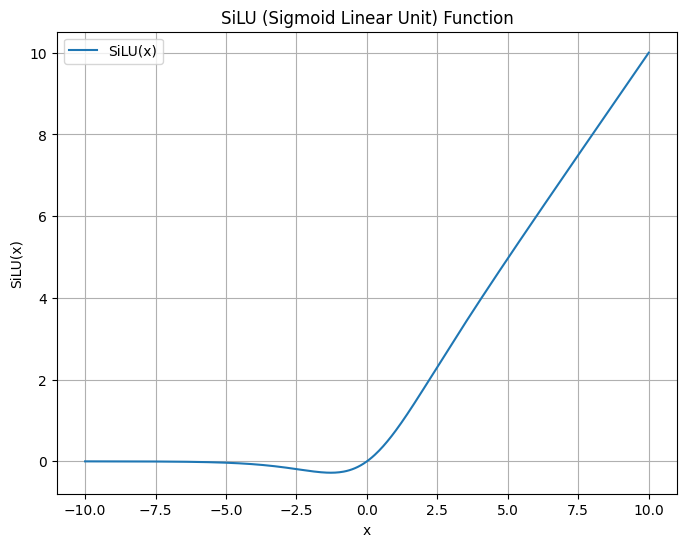

In [ ]:
# @title SiLU function
import numpy as np
import matplotlib.pyplot as plt

def silu(x):
    return x / (1 + np.exp(-x))

# Generate input data
x = np.linspace(-10, 10, 400)
y = silu(x)

# Plot the SiLU function
plt.figure(figsize=(8, 6))
plt.plot(x, y, label='SiLU(x)')
plt.title('SiLU (Sigmoid Linear Unit) Function')
plt.xlabel('x')
plt.ylabel('SiLU(x)')
plt.grid(True)
plt.legend()
plt.show()


SwiGLU

$$\operatorname{SwiGLU}(x) = W_3 \color{green}{\operatorname{Swish}(W_1x+b_1)} \odot (W_2x + b_2)$$

combines the $\color{green}{\text{soft gating mechanism}}$ with smoother gradients than the sigmoid function, with a larger range of non-zero values.
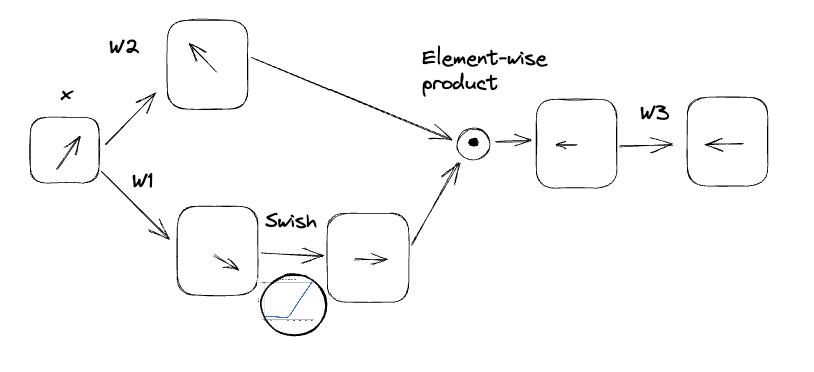

In this notebook we'll implement SwiGLU and compare it with a similar network using ReLU, on a toy dataset.

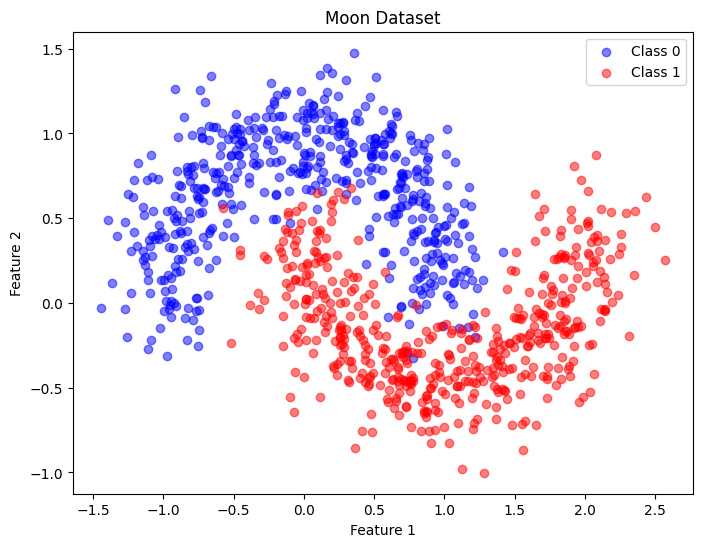

In [ ]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Generate synthetic dataset
X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0', alpha=0.5)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1', alpha=0.5)
plt.title("Moon Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SwiGLU(nn.Module):
    def __init__(self, hidden_dims=100):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden_dims, bias=False)
        self.silu = nn.SiLU()  # x * sigmoid(x)
        self.fc2 = nn.Linear(2, hidden_dims, bias=False)
        self.fc3 = nn.Linear(hidden_dims, 2, bias=False)

    def forward(self, x):
        gate = F.silu(self.fc1(x))
        x = self.fc2(x)
        x = x * gate
        x = self.fc3(x)
        return x

from torch.nn.functional import relu

class SimpleNNReLU(nn.Module):
    def __init__(self, hidden_dims=100):
        super().__init__()
        self.fc1 = nn.Linear(2, hidden_dims, bias=False)
        self.fc2 = nn.Linear(hidden_dims, hidden_dims, bias=False)
        self.fc3 = nn.Linear(hidden_dims, 2, bias=False)

    def forward(self, x):
        x = relu(self.fc1(x))
        x = relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Convert to PyTorch tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)

# Training function
def train_model(model, X_train, y_train, X_test, y_test, epochs=1000, lr=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)  # nn.Module: __call__ -> forward
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == y_test).sum().item() / y_test.size(0)
    return accuracy

# Initialize and train models
model_relu = SimpleNNReLU()
model_swiglu = SwiGLU()

accuracy_relu = train_model(model_relu, X_train, y_train, X_test, y_test)
accuracy_swiglu = train_model(model_swiglu, X_train, y_train, X_test, y_test)

print(f"Accuracy with ReLU: {accuracy_relu:.2f}")
print(f"Accuracy with SwiGLU: {accuracy_swiglu:.2f}")


Accuracy with ReLU: 0.89
Accuracy with SwiGLU: 0.94
